In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/train" "/content/train"

In [3]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/test" "/content/test"

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def load_data(data_dir, batch_size=32, test_split=0.1, seed=42):
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.

    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes


def evaluate(model, loader, device, criterion, dataset_name="Validation"):
    """
    Evaluates the model on the given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        dataset_name (str): Name of the dataset being evaluated

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy


def train_and_test(train_dir, test_dir, model_name='resnet50', fine_tune_strategy='all', num_epochs=5, batch_size=32,
                   learning_rate=0.0001, weight_decay=0.001, k_layers_to_freeze=None):
    """
    Loads the training and testing data, fine-tunes a pre-trained model,
    and evaluates it on the test set.  Logs results to Wandb.

    Args:
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
        model_name (str): Name of the pre-trained model to use (e.g., 'resnet50', 'efficientnet_b0').
        fine_tune_strategy (str): Strategy for fine-tuning ('all', 'classifier_only', 'freeze_up_to_k').
        num_epochs (int): Number of epochs to train for.
        batch_size (int): Batch size for training and testing.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for the optimizer.
        k_layers_to_freeze (int, optional):  If fine_tune_strategy is 'freeze_up_to_k', this specifies
                                            how many layers to freeze.
    Returns:
        None
    """
    wandb.init(project="inaturalist_pytorch_finetuning", job_type="final_run")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=batch_size)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")

    # Load the pre-trained model
    if hasattr(models, model_name):
        model_ft = getattr(models, model_name)(pretrained=True)
    else:
        print(f"Model {model_name} not found in torchvision.models. Available models are:")
        import torchvision.models
        print(dir(torchvision.models))
        return

    # Fine-tuning strategy
    if fine_tune_strategy == 'all':
        print("Fine-tuning all layers.")
        for param in model_ft.parameters():
            param.requires_grad = True  # Ensure all parameters are trainable
    elif fine_tune_strategy == 'classifier_only':
        print("Fine-tuning only the classifier layer.")
        for param in model_ft.parameters():
            param.requires_grad = False
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():  # Only train the new classifier
            param.requires_grad = True
    elif fine_tune_strategy == 'freeze_up_to_k':
        if k_layers_to_freeze is None:
            raise ValueError("k_layers_to_freeze must be specified when fine_tune_strategy is 'freeze_up_to_k'")
        print(f"Freezing the first {k_layers_to_freeze} layers, and fine-tuning the rest.")
        modules = list(model_ft.children())
        for i in range(k_layers_to_freeze):
            for param in modules[i].parameters():
                param.requires_grad = False
        # Ensure the final fully connected layer is trainable
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():
            param.requires_grad = True

    else:
        raise ValueError(f"Invalid fine_tune_strategy: {fine_tune_strategy}")

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    print(f"Fine-tuning {model_name} with strategy '{fine_tune_strategy}' on the full training set...")
    model_ft.train()
    for epoch in range(num_epochs):
        total_train_loss, correct_train, total_train = 0, 0, 0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

    print(f"Finished Training. Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")

    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model_ft, test_loader, device, criterion, dataset_name="Test")
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    wandb.finish()


if __name__ == '__main__':
    train_dir = '/content/train'  # train dataset path
    test_dir = '/content/test'  # test dataset
    # You can change these parameters to experiment with different models and training settings
    model_name = 'resnet50'  # 'resnet50', 'efficientnet_b0', etc.
    num_epochs = 10
    batch_size = 32
    learning_rate = 0.0001
    weight_decay = 0.001

    # Experiment with different fine-tuning strategies
    fine_tuning_strategies = [
        'all',
        'classifier_only',
        'freeze_up_to_k',  # Requires k_layers_to_freeze
    ]

    print("Running fine-tuning experiments:")
    for strategy in fine_tuning_strategies:
        print(f"\n--- Fine-tuning strategy: {strategy} ---")
        if strategy == 'freeze_up_to_k':
            for k in [2, 4, 6]:  # Try freezing different numbers of layers
                print(f"\n--- Freezing up to {k} layers ---")
                train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
                               weight_decay, k_layers_to_freeze=k)
        else:
            train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
                           weight_decay)


Running fine-tuning experiments:

--- Fine-tuning strategy: all ---


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cpu
Number of classes: 10


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


Fine-tuning all layers.
Fine-tuning resnet50 with strategy 'all' on the full training set...
Epoch 1/10


Training:   1%|          | 2/282 [01:33<3:39:13, 46.98s/it]


KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def load_data(data_dir, batch_size=32, test_split=0.1, seed=42):
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.

    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes


def evaluate(model, loader, device, criterion, dataset_name="Validation"):
    """
    Evaluates the model on the given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        dataset_name (str): Name of the dataset being evaluated

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy


def train_and_test(train_dir, test_dir, model_name='googlenet', fine_tune_strategy='all', num_epochs=5, batch_size=32,
                   learning_rate=0.0001, weight_decay=0.001, k_layers_to_freeze=None):
    """
    Loads the training and testing data, fine-tunes a pre-trained model,
    and evaluates it on the test set.  Logs results to Wandb.

    Args:
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
        model_name (str): Name of the pre-trained model to use (e.g., 'resnet50', 'efficientnet_b0').
        fine_tune_strategy (str): Strategy for fine-tuning ('all', 'classifier_only', 'freeze_up_to_k').
        num_epochs (int): Number of epochs to train for.
        batch_size (int): Batch size for training and testing.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for the optimizer.
        k_layers_to_freeze (int, optional):  If fine_tune_strategy is 'freeze_up_to_k', this specifies
                                            how many layers to freeze.
    Returns:
        None
    """
    wandb.init(project="inaturalist_pytorch_finetuning", job_type="final_run")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=batch_size)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")

    # Load the pre-trained model
    if hasattr(models, model_name):
        model_ft = getattr(models, model_name)(pretrained=True)
    else:
        print(f"Model {model_name} not found in torchvision.models. Available models are:")
        import torchvision.models
        print(dir(torchvision.models))
        return

    # Handle GoogLeNet auxiliary outputs
    if model_name == 'googlenet':
        if fine_tune_strategy != 'all':
            print("Warning: GoogLeNet has auxiliary outputs.  Fine-tuning strategy 'classifier_only' and 'freeze_up_to_k' might not work as expected with GoogLeNet.")
        model_ft.aux_logits = False  # Disable auxiliary outputs for simpler fine-tuning

    # Fine-tuning strategy
    if fine_tune_strategy == 'all':
        print("Fine-tuning all layers.")
        for param in model_ft.parameters():
            param.requires_grad = True  # Ensure all parameters are trainable
    elif fine_tune_strategy == 'classifier_only':
        print("Fine-tuning only the classifier layer.")
        for param in model_ft.parameters():
            param.requires_grad = False
        if model_name == 'googlenet':
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        else: #THIS IS THE GENERAL CASE FOR OTHER MODELS
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():  # Only train the new classifier
            param.requires_grad = True
    elif fine_tune_strategy == 'freeze_up_to_k':
        if k_layers_to_freeze is None:
            raise ValueError("k_layers_to_freeze must be specified when fine_tune_strategy is 'freeze_up_to_k'")
        print(f"Freezing the first {k_layers_to_freeze} layers, and fine-tuning the rest.")
        modules = list(model_ft.children())
        for i in range(k_layers_to_freeze):
            for param in modules[i].parameters():
                param.requires_grad = False
        # Ensure the final fully connected layer is trainable
        if model_name == 'googlenet':
              in_features = model_ft.fc.in_features
              model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        else:
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():
            param.requires_grad = True

    else:
        raise ValueError(f"Invalid fine_tune_strategy: {fine_tune_strategy}")

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    print(f"Fine-tuning {model_name} with strategy '{fine_tune_strategy}' on the full training set...")
    model_ft.train()
    for epoch in range(num_epochs):
        total_train_loss, correct_train, total_train = 0, 0, 0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

    print(f"Finished Training. Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")

    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model_ft, test_loader, device, criterion, dataset_name="Test")
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    wandb.finish()


if __name__ == '__main__':
    train_dir = '/content/train'  # train dataset path
    test_dir = '/content/test'  # test dataset
    # You can change these parameters to experiment with different models and training settings
    model_name = 'googlenet'  #  'googlenet'
    num_epochs = 10
    batch_size = 32
    learning_rate = 0.0001
    weight_decay = 0.001

    # Experiment with different fine-tuning strategies
    fine_tuning_strategies = [
        'all',
        'classifier_only',
        'freeze_up_to_k',  # Requires k_layers_to_freeze
    ]

    print("Running fine-tuning experiments:")
    for strategy in fine_tuning_strategies:
        print(f"\n--- Fine-tuning strategy: {strategy} ---")
        if strategy == 'freeze_up_to_k':
            for k in [6]:  # Try freezing different numbers of layers
                print(f"\n--- Freezing up to {k} layers ---")
                train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
                               weight_decay, k_layers_to_freeze=k)
        else:
            train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
                           weight_decay)


Running fine-tuning experiments:

--- Fine-tuning strategy: all ---


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

Running fine-tuning experiments:

--- Fine-tuning strategy: all ---

--- Fine-tuning strategy: classifier_only ---

--- Fine-tuning strategy: freeze_all_except_last ---


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda
Number of classes: 10


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 119MB/s]



GoogLeNet Architecture:
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentu

Training: 100%|██████████| 282/282 [01:44<00:00,  2.70it/s]


Epoch 1 Training Loss: 2.0974, Training Accuracy: 0.3369
Epoch 2/10


Training: 100%|██████████| 282/282 [01:32<00:00,  3.03it/s]


Epoch 2 Training Loss: 1.7346, Training Accuracy: 0.5634
Epoch 3/10


Training: 100%|██████████| 282/282 [01:33<00:00,  3.00it/s]


Epoch 3 Training Loss: 1.5097, Training Accuracy: 0.6123
Epoch 4/10


Training: 100%|██████████| 282/282 [01:31<00:00,  3.07it/s]


Epoch 4 Training Loss: 1.3728, Training Accuracy: 0.6234
Epoch 5/10


Training: 100%|██████████| 282/282 [01:31<00:00,  3.07it/s]


Epoch 5 Training Loss: 1.2773, Training Accuracy: 0.6394
Epoch 6/10


Training: 100%|██████████| 282/282 [01:33<00:00,  3.03it/s]


Epoch 6 Training Loss: 1.2174, Training Accuracy: 0.6488
Epoch 7/10


Training: 100%|██████████| 282/282 [01:31<00:00,  3.09it/s]


Epoch 7 Training Loss: 1.1719, Training Accuracy: 0.6531
Epoch 8/10


Training: 100%|██████████| 282/282 [01:33<00:00,  3.00it/s]


Epoch 8 Training Loss: 1.1335, Training Accuracy: 0.6613
Epoch 9/10


Training: 100%|██████████| 282/282 [01:31<00:00,  3.07it/s]


Epoch 9 Training Loss: 1.1069, Training Accuracy: 0.6600
Epoch 10/10


Training: 100%|██████████| 282/282 [01:33<00:00,  3.02it/s]

Epoch 10 Training Loss: 1.0879, Training Accuracy: 0.6708
Finished Training. Final Training Loss: 1.0879, Final Training Accuracy: 0.6708
Evaluating on the test set...


Test Loss: 1.0080 Test Accuracy: 0.6947


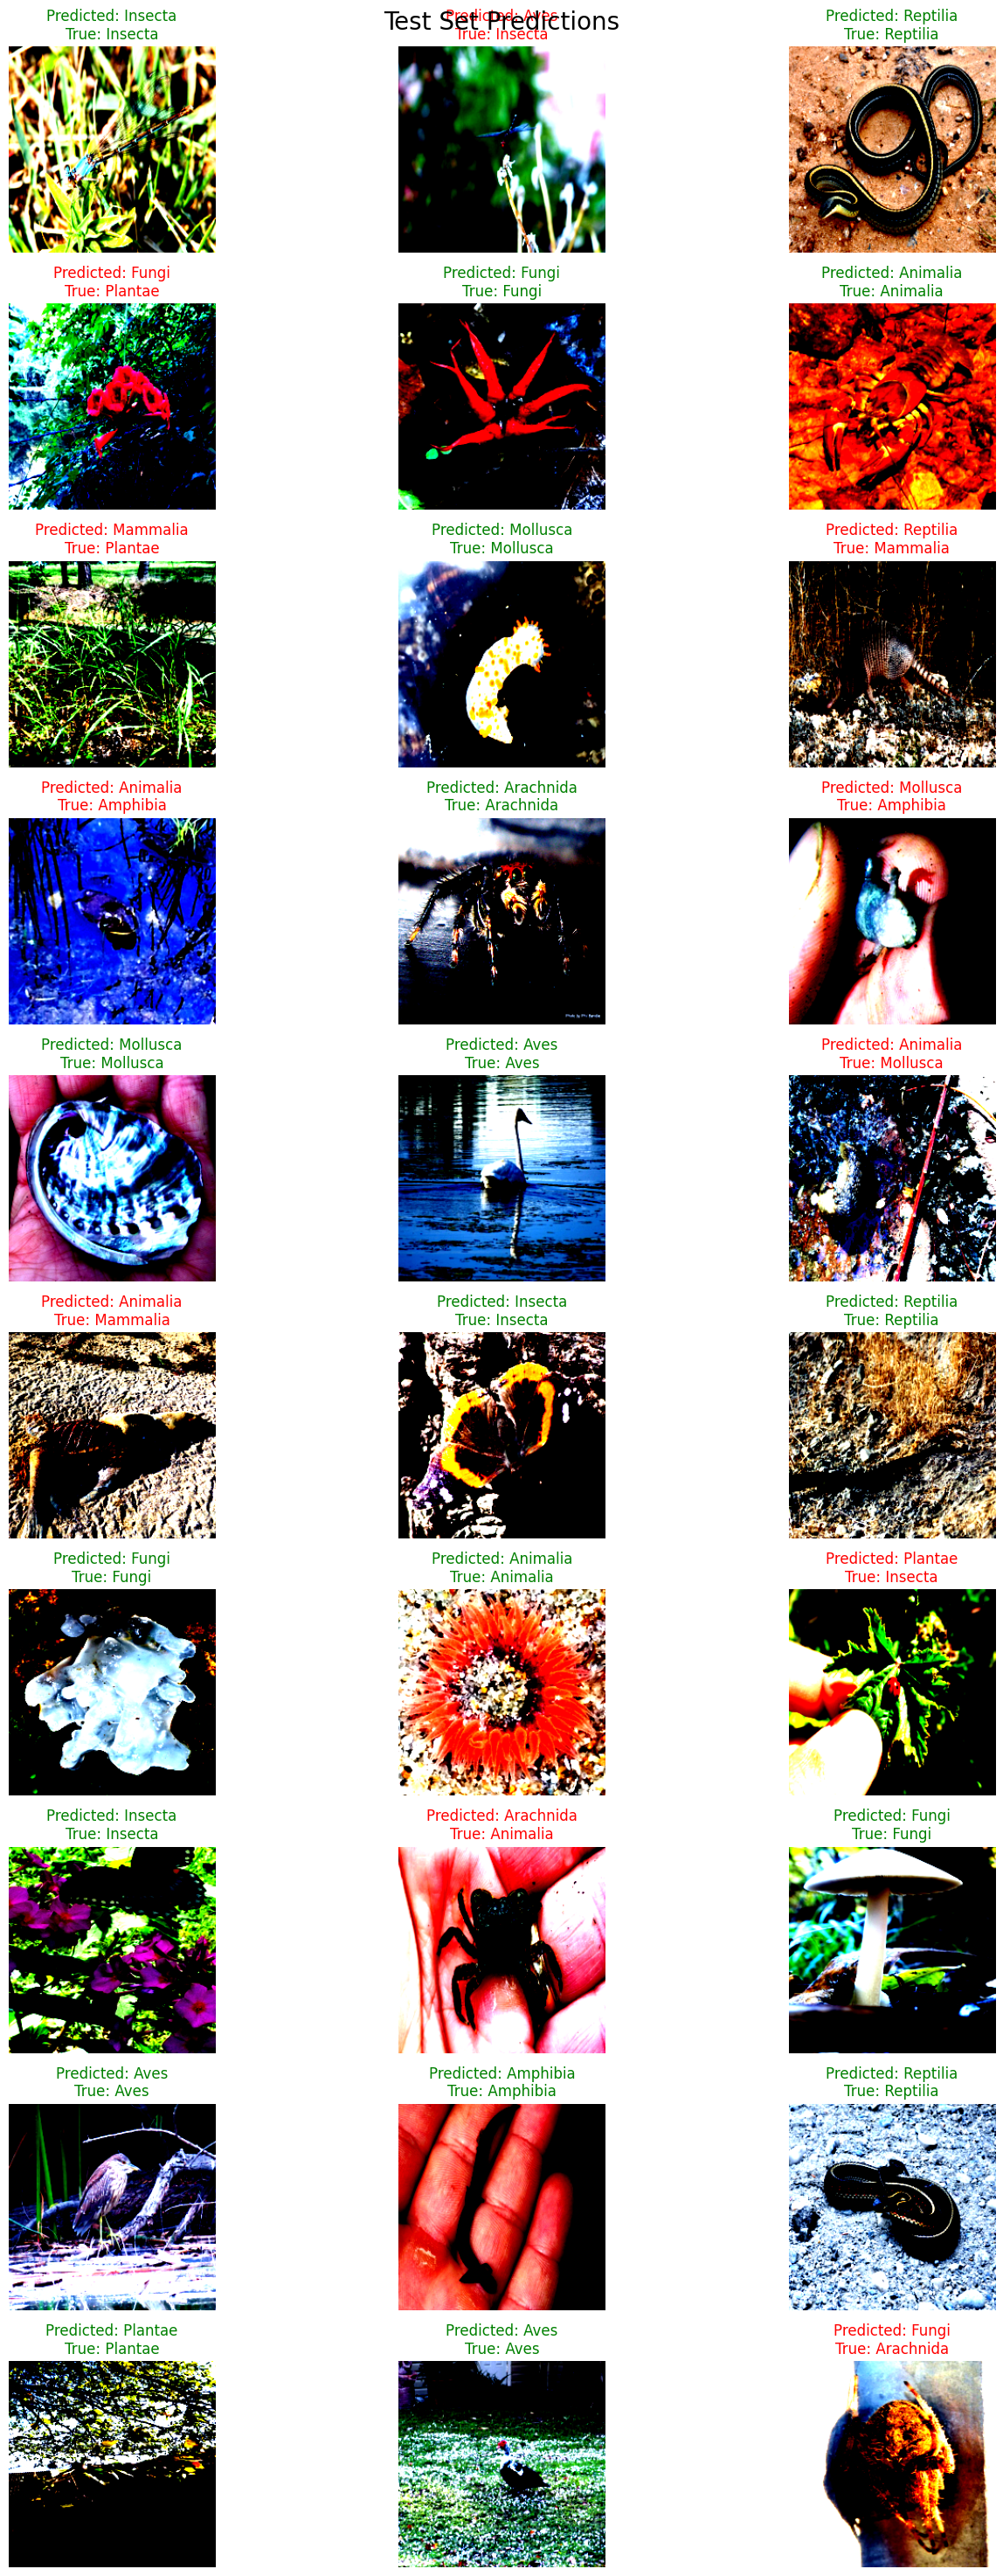

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
test_accuracy,0.69469
test_loss,1.00801
train_accuracy,0.67078
train_loss,1.08788


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def load_data(data_dir, batch_size=32, test_split=0.1, seed=42):
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.

    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes


def evaluate(model, loader, device, criterion, dataset_name="Validation"):
    """
    Evaluates the model on the given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        dataset_name (str): Name of the dataset being evaluated

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy


def train_and_test(train_dir, test_dir, model_name='googlenet', fine_tune_strategy='all', num_epochs=5, batch_size=32,
                   learning_rate=0.0001, weight_decay=0.001, k_layers_to_freeze=None):
    """
    Loads the training and testing data, fine-tunes a pre-trained model,
    and evaluates it on the test set.  Logs results to Wandb.

    Args:
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
        model_name (str): Name of the pre-trained model to use (e.g., 'resnet50', 'efficientnet_b0').
        fine_tune_strategy (str): Strategy for fine-tuning ('all', 'classifier_only', 'freeze_up_to_k').
        num_epochs (int): Number of epochs to train for.
        batch_size (int): Batch size for training and testing.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for the optimizer.
        k_layers_to_freeze (int, optional):  If fine_tune_strategy is 'freeze_up_to_k', this specifies
                                            how many layers to freeze.
    Returns:
        None
    """
    wandb.init(project="inaturalist_pytorch_finetuning", job_type="final_run")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=batch_size)
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")

    # Load the pre-trained model
    if hasattr(models, model_name):
        model_ft = getattr(models, model_name)(pretrained=True)
    else:
        print(f"Model {model_name} not found in torchvision.models. Available models are:")
        import torchvision.models
        print(dir(torchvision.models))
        return

    # Handle GoogLeNet auxiliary outputs
    if model_name == 'googlenet':
        if fine_tune_strategy != 'all':
            print(
                "Warning: GoogLeNet has auxiliary outputs.  Fine-tuning strategy 'classifier_only' and 'freeze_up_to_k' might not work as expected with GoogLeNet.")
        model_ft.aux_logits = False  # Disable auxiliary outputs for simpler fine-tuning

    # Print the model architecture and count layers
    print("\nGoogLeNet Architecture:")
    print(model_ft)

    total_layers = 0
    for name, module in model_ft.named_modules():
        if len(list(module.children())) == 0:  # Count only leaf nodes (layers with no sub-layers)
            total_layers += 1
    print(f"\nTotal number of layers in GoogLeNet: {total_layers}")

    # Fine-tuning strategy
    if fine_tune_strategy == 'all':
        print("Fine-tuning all layers.")
        for param in model_ft.parameters():
            param.requires_grad = True  # Ensure all parameters are trainable
    elif fine_tune_strategy == 'classifier_only':
        print("Fine-tuning only the classifier layer.")
        for param in model_ft.parameters():
            param.requires_grad = False
        if model_name == 'googlenet':
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        else:  # THIS IS THE GENERAL CASE FOR OTHER MODELS
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():  # Only train the new classifier
            param.requires_grad = True
    elif fine_tune_strategy == 'freeze_up_to_k':
        if k_layers_to_freeze is None:
            raise ValueError(
                "k_layers_to_freeze must be specified when fine_tune_strategy is 'freeze_up_to_k'")
        print(f"Freezing the first {k_layers_to_freeze} layers, and fine-tuning the rest.")
        modules = list(model_ft.children())
        for i in range(k_layers_to_freeze):
            for param in modules[i].parameters():
                param.requires_grad = False
        # Ensure the final fully connected layer is trainable
        if model_name == 'googlenet':
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        else:
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():
            param.requires_grad = True
    elif fine_tune_strategy == 'freeze_all_except_last':
        print("Freezing all layers except the last (classifier) layer.")
        for name, param in model_ft.named_parameters():
            if 'fc' not in name:  # Freeze all layers except the final fully connected layer
                param.requires_grad = False
            else:
                param.requires_grad = True # Make sure the last layer is trainable
        if model_name == 'googlenet':
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        else:
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(in_features, num_classes).to(device)
        for param in model_ft.fc.parameters():
            param.requires_grad = True
    else:
        raise ValueError(f"Invalid fine_tune_strategy: {fine_tune_strategy}")

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)



    # Train the model
    print(f"Fine-tuning {model_name} with strategy '{fine_tune_strategy}' on the full training set...")
    model_ft.train()
    for epoch in range(num_epochs):
        total_train_loss, correct_train, total_train = 0, 0, 0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

    print(f"Finished Training. Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")

    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model_ft, test_loader, device, criterion, dataset_name="Test")
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    # Visualize predictions on the test set
    visualize_predictions(model_ft, test_loader, class_names, device)
    wandb.finish()


def visualize_predictions(model, test_loader, class_names, device, num_images=30):
    """
    Visualizes a grid of images from the test set with their predicted and true labels.
    Logs the visualization to Wandb as an image.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): The DataLoader for the test set.
        class_names (list): A list of class names.
        device (torch.device): The device to use (CPU or GPU).
        num_images (int): The number of images to visualize.  Must be a multiple of 3.
    """
    model.eval()
    images, labels = next(iter(test_loader))  # Get a batch of images
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(15, 30))  # Adjust figure size as needed.
    fig.suptitle("Test Set Predictions", fontsize=20)
    for i in range(num_images):
        plt.subplot(10, 3, i + 1)  # Grid of 10 rows, 3 columns
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert to HWC and to numpy
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                  color=("green" if predicted[i] == labels[i] else "red"))  # Color-code correct/incorrect
    plt.tight_layout()  # Adjust layout so titles don't overlap

    # Log the figure to Wandb
    wandb.log({"test_set_predictions": fig})
    plt.show() #show the plot

if __name__ == '__main__':
    train_dir = '/content/train'  # train dataset path
    test_dir = '/content/test'  # test dataset
    # You can change these parameters to experiment with different models and training settings
    model_name = 'googlenet'  # 'googlenet'
    num_epochs = 10
    batch_size = 32
    learning_rate = 0.0001
    weight_decay = 0.001

    # Experiment with different fine-tuning strategies
    fine_tuning_strategies = [
        'all',
        'classifier_only',
        'freeze_all_except_last' # New strategy
    ]

    print("Running fine-tuning experiments:")
    for strategy in fine_tuning_strategies:
        print(f"\n--- Fine-tuning strategy: {strategy} ---")
        # train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
        #                    weight_decay)

    strategy='classifier_only'
    train_and_test(train_dir, test_dir, model_name, strategy, num_epochs, batch_size, learning_rate,
                           weight_decay)
